# Regression models

Methodological decisions
* Drop constant to avoid dummy trap (since there isn't any argument in favor of picking any specific country as a baseline)
* Standardize Average rating to avoid VIF problems in the moderation

In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import corrcoef

In [2]:
data = pd.read_parquet('../10-data/data_final.parquet')
print(data.shape)
data.head()

(4768, 284)


,Title,Year,Country,BoxOffice,runtimeMinutes,genres,averageRating,numVotes,isRated,ForeignLanguage,...,won_Oscar,plot_sentiment_polarity,plot_sentiment_score,isPositivePlot,isFiction,Competitiveness,Cooperativeness,logBoxOffice,logRunTime,logNumVotes
0,Shadow Play,1996,"[France, United Kingdom]",3.053799e+04,111.0,"Comedy,Romance",5.8,495,False,False,...,False,positive,0.996212,1.0,True,8.563351,9.607148,10.326727,4.709530,6.204558
1,Down by Love,2016,"[France, Belgium]",8.230545e+02,110.0,"Biography,Drama,Romance",5.9,2296,True,False,...,False,positive,0.998860,1.0,True,11.997840,10.791093,6.713022,4.700480,7.738924
2,Heavenly Bodies,1984,[Canada],5.182512e+06,89.0,"Drama,Romance",5.2,882,True,True,...,False,negative,0.993147,0.0,True,7.111757,8.025091,15.460800,4.488636,6.782192
3,High Season,1987,[United Kingdom],2.897574e+06,90.0,"Comedy,Romance",5.3,459,True,False,...,False,positive,0.989917,1.0,True,7.748589,8.581463,14.879384,4.499810,6.129050
4,Bright Days Ahead,2013,[France],2.734882e+04,94.0,"Drama,Romance",6.3,1843,False,False,...,False,positive,0.995390,1.0,True,11.164641,12.082496,10.216429,4.543295,7.519150


# Define data subsets

### main variables and covariates

In [3]:
main_variables = data[['Cooperativeness',
                        'Competitiveness']]
main_variables.head()

,Cooperativeness,Competitiveness
0,9.607148,8.563351
1,10.791093,11.997840
2,8.025091,7.111757
3,8.581463,7.748589
4,12.082496,11.164641


In [23]:
main_covariates = data[['logRunTime',
                        'averageRating',
                        'isRated',
                        'ForeignLanguage',
                        'isCoproduction',
                        'win_award',
                        'nominated_award',
                        'won_Oscar',
                        'plot_sentiment_score',
                        'isPositivePlot',
                        'isFiction']].astype('float64')

main_covariates.head()

,logRunTime,averageRating,isRated,ForeignLanguage,isCoproduction,win_award,nominated_award,won_Oscar,plot_sentiment_score,isPositivePlot,isFiction
0,4.709530,-0.859117,0.0,0.0,1.0,1.0,1.0,0.0,0.996212,1.0,1.0
1,4.700480,-0.750344,1.0,0.0,1.0,0.0,0.0,0.0,0.998860,1.0,1.0
2,4.488636,-1.511753,1.0,1.0,0.0,0.0,0.0,0.0,0.993147,0.0,1.0
3,4.499810,-1.402980,1.0,0.0,0.0,1.0,0.0,0.0,0.989917,1.0,1.0
4,4.543295,-0.315254,0.0,0.0,0.0,0.0,1.0,0.0,0.995390,1.0,1.0


### moderating variables

In [25]:
#Standardize averageRating in all models, so as to avoid VIF problems ahead
main_covariates['averageRating'] = (main_covariates.averageRating - main_covariates.averageRating.mean())/main_covariates.averageRating.std()

moderating_vars = pd.DataFrame({'Rating moderation on Cooperativeness': main_covariates['averageRating'] * main_variables['Cooperativeness'],
                                'Rating moderation on Competitiveness': main_covariates['averageRating'] * main_variables['Competitiveness']})

moderating_vars.head()

,Rating moderation on Cooperativeness,Rating moderation on Competitiveness
0,-8.253665,-7.356921
1,-8.097036,-9.002512
2,-12.131957,-10.751221
3,-12.039625,-10.871119
4,-3.809052,-3.519694


In [45]:
corrcoef(main_covariates['averageRating'], moderating_vars['Rating moderation on Cooperativeness'])

array([[1.        , 0.98328009],
       [0.98328009, 1.        ]])

In [46]:
corrcoef(main_covariates['averageRating'], moderating_vars['Rating moderation on Competitiveness'])

array([[1.        , 0.98362193],
       [0.98362193, 1.        ]])

In [51]:
corrcoef(main_covariates['averageRating'], main_variables['Cooperativeness'])

array([[ 1.        , -0.08633457],
       [-0.08633457,  1.        ]])

In [50]:
corrcoef(main_covariates['averageRating'], main_variables['Competitiveness'])

array([[ 1.        , -0.07120028],
       [-0.07120028,  1.        ]])

### year and country dummies

In [26]:
#Define year dummies aux dataframe
year_dummies = data.loc[:,data.columns.str.startswith('Year_')]
year_dummies.head()

,Year_1980,Year_1981,Year_1982,Year_1983,Year_1984,Year_1985,Year_1986,Year_1987,Year_1988,Year_1989,...,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
country_dummies = data.loc[:,data.columns.str.startswith('dmy')]
country_dummies.head()

,dmy Cyprus,dmy Kosovo,dmy United Arab Emirates,dmy United Kingdom,dmy Ireland,dmy Cameroon,dmy Azerbaijan,dmy West Germany,dmy Hungary,dmy Chad,...,dmy Slovakia,dmy Ukraine,dmy Bulgaria,dmy Australia,dmy Sweden,dmy Turkey,dmy Nigeria,dmy Serbia and Montenegro,dmy Tanzania,dmy Romania
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# OLS models

## Baseline model (just year and country dummies)

In [28]:
X = pd.concat([year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

ols_baseline = sm.OLS(y, X).fit()
#print(ols_baseline.summary())

## Covariates model

In [29]:
X = pd.concat([main_covariates, year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

ols_covs = sm.OLS(y, X).fit()
#print(ols_covs.summary())

## Covariates + Cooperativeness

In [30]:
X = pd.concat([data['Cooperativeness'] ,main_covariates, year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

ols_coop = sm.OLS(y, X).fit()
#print(ols_coop.summary())

## Covariates + Competitiveness

In [31]:
X = pd.concat([data['Competitiveness'], main_covariates, year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

ols_comp = sm.OLS(y, X).fit()
#print(ols_comp.summary())

## Full model, no moderation

In [32]:
X = pd.concat([main_variables, main_covariates, year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

ols_full_nomod = sm.OLS(y, X).fit()
#print(ols_full_nomod.summary())

## Full model, with moderation

In [34]:
X = pd.concat([main_variables, moderating_vars, main_covariates, year_dummies, country_dummies], axis=1)
y = data['logBoxOffice']

#Run regression
ols_full_yesmod = sm.OLS(y, X).fit()
#print(ols_full_yesmod.summary())

## OLS models comparison

In [35]:
from stargazer.stargazer import Stargazer, LineLocation

stargazer = Stargazer([ ols_baseline,
                       ols_covs, 
                       ols_comp,
                       ols_coop,
                       ols_full_nomod,
                       ols_full_yesmod,])
stargazer.covariate_order(X.columns)
stargazer.custom_columns(['Trend only', 
                          'Covariates only', 
                          'Competitiveness & covs',
                          'Cooperation & covs',
                          'Full model, no moderation',
                          'Full model, with moderation'
                         ], [1,1,1,1,1,1])
stargazer.show_model_numbers(True)
stargazer

## Diagnostics

In [36]:
model=ols_full_yesmod

# Extract residuals and fitted values
Zres = model.resid/model.resid.std()
yhat = model.fittedvalues

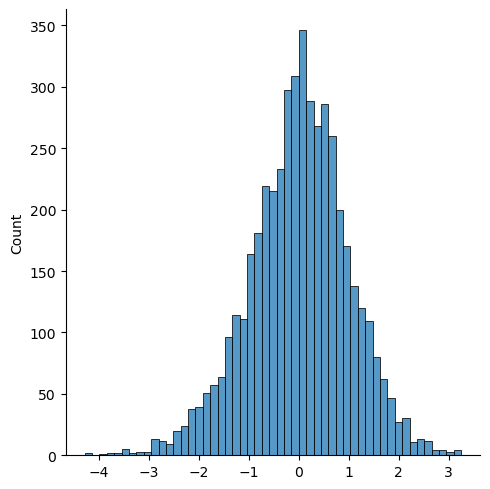

In [37]:
sns.displot(Zres)

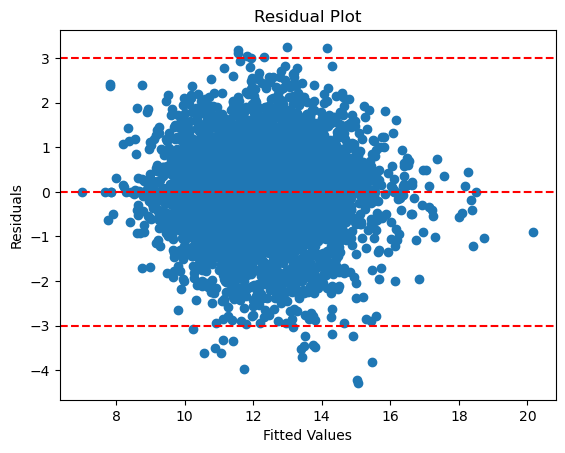

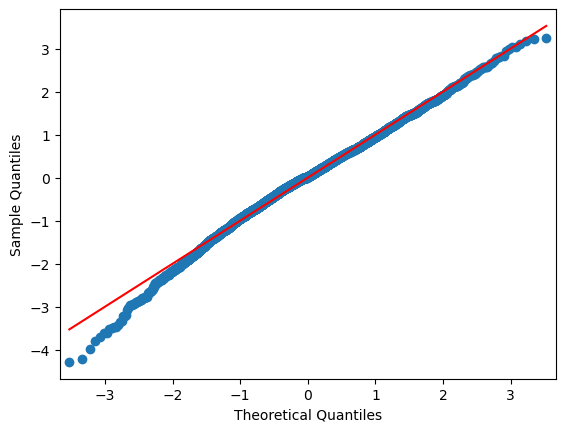

In [38]:
# Plot residuals
plt.scatter(yhat, Zres)
plt.axhline(y=Zres.mean(), c='red', linestyle='dashed')
plt.axhline(y=-3, c='red', linestyle='dashed')
plt.axhline(y=+3, c='red', linestyle='dashed')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# QQ plot for residuals
sm.qqplot(Zres, line='s')
plt.show()


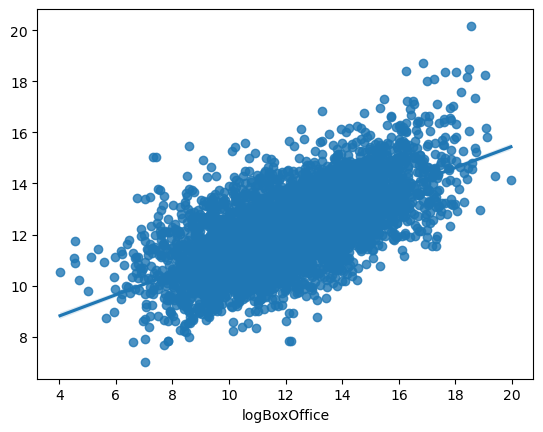

In [39]:
sns.regplot(x=y, y=yhat);

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.concat([main_variables, main_covariates, moderating_vars], axis=1)

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif.sort_values('VIF', ascending=False)

,VIF,variable
2,130.914616,logRunTime
0,118.376260,Cooperativeness
1,118.004081,Competitiveness
10,78.360135,plot_sentiment_score
14,73.452815,Rating moderation on Competitiveness
13,72.093095,Rating moderation on Cooperativeness
3,36.003147,averageRating
12,27.944979,isFiction
8,8.368706,nominated_award
7,5.477593,win_award


In [41]:
corrcoef(data.Competitiveness, data.Cooperativeness)

array([[1.        , 0.73223444],
       [0.73223444, 1.        ]])

<Axes: >

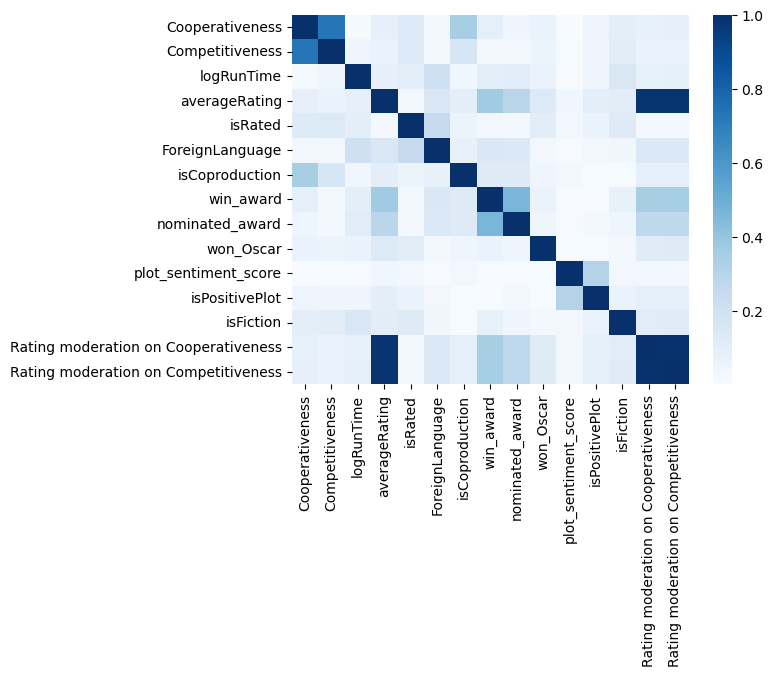

In [43]:
sns.heatmap(X.corr().abs(), cmap='Blues')

In [ ]:
#Influente measures are defined only for OLS
infl = model.get_influence().summary_frame()

In [ ]:
# residuals beyond 3 standard deviations
(infl.standard_resid.abs() > 3).mean()

In [ ]:
#Cook's D
infl.cooks_d.max()

In [ ]:
(infl.cooks_d > np.sqrt(4/len(data))).sum()

In [ ]:
#Leverage
infl.hat_diag.max()

In [ ]:
#DFFits
infl.dffits.min(), infl.dffits.max()

In [ ]:
#DFBetas
for c in infl.loc[:,infl.columns.str.startswith('dfb_')]:
    print(f'{c}, {infl[c].min():.2f}, {infl[c].max():.2f}')
    

In [ ]:
data.loc[infl[infl.standard_resid.abs()>4].index,:]

In [ ]:
data.BoxOffice.describe()

In [ ]:
X.drop(columns=['const']).corr().to_excel('../30-output/correlations.xlsx')

# Make some tables

In [ ]:
eda = X.drop(columns=['const']).describe()
eda

In [ ]:
eda.to_excel('../30-output/EDA.xlsx')